<a href="https://colab.research.google.com/github/willewiik/Time-Series-and-Sequence-Learning/blob/main/old_exams/exam_21_10_26_TS/Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
!git clone https://github.com/willewiik/Time-Series-and-Sequence-Learning.git

Cloning into 'Time-Series-and-Sequence-Learning'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 54 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 884.08 KiB | 6.85 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [14]:
%cd "Time-Series-and-Sequence-Learning/old_exams/exam_21_10_26_TS"

/content/Time-Series-and-Sequence-Learning/old_exams/exam_21_10_26_TS


In [9]:
from tssltools import acf

# Problem 3
(12 points)

We ask a poplutaion of $\mathcal{P}$ persons a yes/no question every week for three year and record the number of yes answers. Every persons answer is assumed to be independent of each other. We model the probability of any single person answering yes in week $t$ as $\alpha_t$, and assume the following dynamics for this process,
$$
    \alpha_{t+1} = \left(1 + \exp\left[ - a \cdot \log \left( \frac{\alpha_t}{1 - \alpha_t} \right) + \sigma \cdot \eta_{t+1} \right] \right)^{-1}, \quad \eta_{t+1} \sim \mathcal{N}(0,1)
$$
we let $\alpha_1 \sim \mathcal{U}(0,1)$ (_uniform distribution_).

**a)** We are interested in estimating the probabilities $\alpha_t$ given the sum of yes answers $y_{1:t}$, since this is a non-linear non-Gaussian model we will use a *bootstrap particle filter* to solve this problem. To implement such an algorithm we need to perform three operations, propagation, weighting, and resampling. In this first problem you should do the following:
1. Find the conditional distribution of $y_t \mid \alpha_t$.
2. Implement a function that takes $N$ particles $\alpha_t^i$ and propagates them to $\alpha_{t+1}^{i}$.
3. Implement a function that takes $N$ particles $\alpha_t^i$ and an observation $y_t$ and calculates the log-weights $\log \omega_t^i$.
<div style='text-align: right'>(4p)</div>

1. The conditional distribution of $y_t|\alpha_t \sim BIN(P,\alpha_t)$

$\alpha_t^y(1-\alpha_t)^{P-y}$

**Solution:**

In [46]:
# 1 ############

#help(np.random.binomial)
# 2
#from tssstool import
def prop(particles,N, a, sigma):
   eta_t_plus_1 = np.random.normal(0, 1, N)
   alpha_t_plus_one = (1 + np.exp(-a * np.log(particles / (1- particles) + sigma * eta_t_plus_1)))**-1
   return alpha_t_plus_one




# 3
# y * log(alphat) + (P-y)*log(1-alphat)
def log_weight(y, alphat, P):
  logwgt = y * np.log(alphat) + (P-y)*np.log(1-alphat)
  return logwgt

___

**b)** using the functions from the previous part implement a **botstrap particle filter** that runs on the data available in the file `data_problem3.csv`. Use the parameter values $a = 0.9, \sigma = 0.5$, and $\mathcal{P} = 130$.

Provide a plot of your estimate of the sequences $\mathbb{E}[\alpha_t \mid y_{1:t}]$ and $\mathbb{P}(\alpha_t > 0.5 \mid y_{1:t})$, for $t = 1, 2, \ldots, 156$. You should use at least $N = 200$ particles in your estimates.

_hint: note that $\mathbb{P}(\alpha_t > 0.5 \mid y_{1:t}) = \mathbb{E}[ I\{\alpha_t > 0.5\} \mid y_{1:t}]$, where $I\{ \cdot \}$ is an indicator function that is $1$ when the condition is satisfied and $0$ otherwise._
(_if you failed to solve part a you can use `propagate_wrong` and `logwgtfun_wrong` from `tssltools.py`_)
<div style="text-align: right"> (5p) </div>

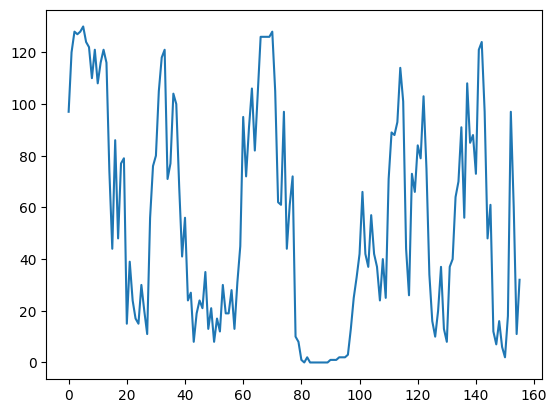

In [47]:
data = pd.read_csv('data_problem3.csv',header=0)
y = data['Data'].values
plt.plot(y)

**Solution:**

In [59]:
from tssltools import smc_res

def exp_norm(logwgt):
  logwgt_max = np.max(logwgt)
  logwgt_tilde = logwgt - logwgt_max
  wgt = np.exp(logwgt_tilde)
  wgt = wgt / np.sum(wgt)
  logZ = np.log(np.sum(wgt)) + logwgt_max
  return wgt, logZ


def ESS(wgt):
  ess = np.sum(wgt)**2 / np.sum(wgt**2)
  return ess

def bpf(y, numParticles, alpha, sigma, P):
   n = len(y)
   N = numParticles
   particles = np.zeros((N,n), dtype = float)
   logW = np.zeros((N,n))
   W = np.zeros((N,n))
   alpha_filt = np.zeros((1,n))
   N_eff = np.zeros(n)
   logZ = 0
   for t in range(n):
    if t == 0:
      particles[:,0] = np.random.rand(N)
    else:
      ind = np.random.choice(N,N, replace = True, p = W[:,t-1])
      resampled_particles = particles[ind,t-1]
      particles[:,t] = prop(resampled_particles, N, alpha, sigma)

    logW[:,t] = log_weight(y[t], particles[:,t], P)
    W[:,t], logZ_now = exp_norm(logW[:,t])
    logZ += (logZ_now - np.log(N))
    N_eff[t] = ESS(W[:,t])
    alpha_filt[0,t] = np.sum(W[:,t] * particles[:,t])
    return smc_res(alpha_filt,particles,W, N_eff, logZ)

In [65]:
exp_norm(((3,4)))

(array([0.26894142, 0.73105858]), 4.0)

[[0.75442351 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

ValueError: x and y must have same first dimension, but have shapes (156,) and (1, 156)

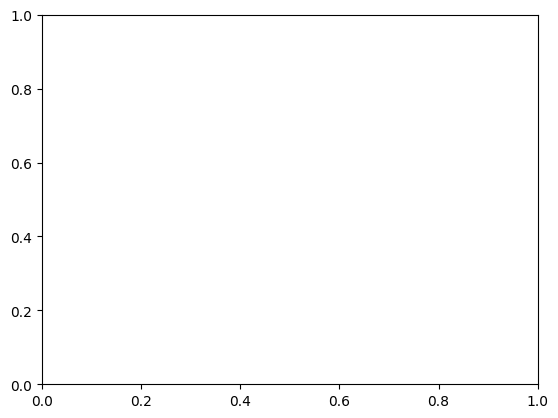

In [63]:
bpf_result = bpf(y = y, numParticles = 200, alpha = 0.9, sigma = 0.5, P = 130)
print(bpf_result.alpha_filt)
n = len(y)
greater_than_onehalf = [sum(bpf_result.particles[:,x]>0.5)/200 for x in range(n)]
u = data.iloc[:,0].values
plt.plot(u,bpf_result.alpha_filt,label = 'alpha_t')
plt.title('Expected alpha_t value given data')
plt.legend()
plt.show()

plt.plot(u,greater_than_onehalf,label = 'probability')
plt.title('probability of alpha_t greater then 0.5 given data')
plt.legend()
plt.show()

___

**c)** The parameter $a$ is set quite arbitrary in the model above. In this problem you should perform parameter inference on this parameter. Find the value of $a$ by calculating the log-likelihood for different values of $a$, you know that the value is between $0.5$ and $1$. Find an estimate of $a$ that would be within $0.05$ of the true value.
<div style="text-align: right">(3p)</div>

**Solution:**